In [50]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

geo_topo = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Hsmooth_geo_topo.txt')
energy_grad = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Hsmooth_energygrad.txt')
other = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Lsmooth_otherinfo_normdist_formal.txt')
mean_field = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Hsmooth_mean_field.txt')
# mask_good_face = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190718_Hsmooth_mask_good_face.txt')
da = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Hsmooth_dihedral_ang.txt')


geo_topo.columns = geo_topo.columns.str.strip()
energy_grad.columns = energy_grad.columns.str.strip()
other.columns = other.columns.str.strip()
mean_field.columns = mean_field.columns.str.strip()
da.columns = da.columns.str.strip()
# mask_good_face.columns = mask_good_face.columns.str.strip()

geo_topo = geo_topo.drop(['fMs_signed_an4'], axis=1)

geo_topo = geo_topo.astype('float')
energy_grad = energy_grad.astype('float')
other = other.astype('float')
mean_field = mean_field.astype('float')
# mask_good_face = mask_good_face.astype('bool')
da = da.astype('float')


# geo_topo.info()
# energy_grad.info()
# mean_field.info()
# other.info()

# ----------------- Paper Feature Correlation Mat -----------------
# other = other.iloc[:, :-8]
# data = pd.concat([other, geo_topo.iloc[:,[0,1,2,5,6,8,3,4]], da.iloc[:, [0,1,2]], \
#                   geo_topo.iloc[:,[9, 10]], da.iloc[:, [3,4,5]], \
#                   mean_field.iloc[:,[0,1,2,3,5,6,7,4,8,9,10,11,12]], \
#                   energy_grad], axis=1)
# ----------------- For Models -----------------
da = da[['da_len_w_an4_opp', 'da_len_w_diff_opp']]
energy_grad = energy_grad[['gV_diff_an4', 'fMs_an4_left']]
other = other.iloc[:, :-8]
data = pd.concat([other, geo_topo.iloc[:,[0,1,2,5,6,8,3,4]], da.iloc[:, 0], \
                  geo_topo.iloc[:,[9, 10]], da.iloc[:, 1], \
                  mean_field.iloc[:,[0,1,2,3,5,6,7,4,8,9,10,11,12]], \
                  energy_grad], axis=1)

data = data.dropna()

mask_complete = data['mask_complete'].astype(bool)
mask_one_piece = data['mask_onepiece'].astype(bool)
area_an4 = data[['A_an4']].values
area_an5 = data[['A_an4']].values + data[['A_diff']].values
area_diff_ratio = (area_an5 - area_an4) / area_an4
mask_not_extreme = np.all([area_an4 > 20, area_an5 > 20, area_diff_ratio < 10, area_diff_ratio > -0.9], axis=0)
# mask = np.all([mask_complete, mask_one_piece, mask_not_extreme.squeeze()], axis=0)
mask = np.all([mask_complete, mask_not_extreme.squeeze()], axis=0)
data = data[mask]

data = data.drop(['mask_complete', 'mask_onepiece'], axis=1)
data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 6447 entries, 82 to 10886
Data columns (total 28 columns):
dist_twin_an4         6447 non-null float64
A_an4                 6447 non-null float64
fMs_abs_an4           6447 non-null float64
avg_FabsavgH_an4      6447 non-null float64
A_diff                6447 non-null float64
fMs_abs_diff          6447 non-null float64
avg_FabsavgH_diff     6447 non-null float64
C_an4                 6447 non-null float64
E_an4                 6447 non-null float64
da_len_w_an4_opp      6447 non-null float64
C_diff                6447 non-null float64
E_diff                6447 non-null float64
da_len_w_diff_opp     6447 non-null float64
E_Enn                 6447 non-null float64
abs_gf_gfnn           6447 non-null float64
pos_frac              6447 non-null float64
twin_frac             6447 non-null float64
grow_frac             6447 non-null float64
disappeared_frac      6447 non-null float64
appeared_frac         6447 non-null float64
total_dann 

In [51]:
def get_sign(data, eps):
    data_sign = np.zeros([data.shape[0], 1])
    mask_pos = data > eps
    mask_neg = data < - eps
    data_sign[mask_pos] = 1
    data_sign[mask_neg] = -1
    return data_sign.ravel()

def calc_class_weights(y):
    weights = np.ones(y.shape)
    for _class in np.unique(y):
        weights[y==_class] = float(np.sum(y==_class)) / y.shape[0]
    return weights

eps_area = 20
area_diff_sign = get_sign(data['A_diff'], eps_area)
print '#stable = ', np.sum(area_diff_sign == 0), ';   #grow = ', np.sum(area_diff_sign > 0), \
    ';   #shrink = ', np.sum(area_diff_sign < 0)


#stable =  937 ;   #grow =  2478 ;   #shrink =  3032


## Reference
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
- https://stats.stackexchange.com/questions/2151/how-to-plot-roc-curves-in-multiclass-classification

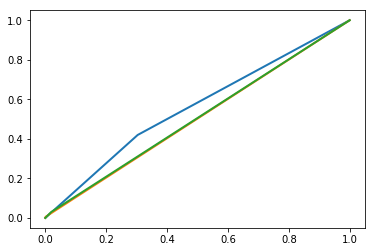

In [67]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold

n_classes = 3
# ---------------- Model ----------------
xgb1 = XGBClassifier(
                     objective='multi:softmax',
                     num_class = 3,
                     eval_metric='mlogloss',
                     learning_rate =0.1,
                     n_estimators=100,
                     max_depth=3,
                     min_child_weight=1,
                     gamma=0,
                     colsample_bytree=0.3
                    )

y = area_diff_sign.astype(int).reshape(-1, 1)
y = MultiLabelBinarizer().fit_transform(y)
X = data[['fMs_abs_an4', 'abs_gf_gfnn']]
weights = calc_class_weights(y)
X = X / X.max(axis=0) *10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


clf = OneVsRestClassifier(xgb1)

# # ---------------- Cross validation ----------------
# # ----- auto -----
# # cross_val = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
# # ----- manual -----
# cv = StratifiedKFold(n_splits=6)
# fpr = [[[] for i in range(5)]for i in range(3)]
# tpr = [[[] for i in range(5)]for i in range(3)]
# aucs = [[None for i in range(5)]for i in range(3)]
# mean_fpr = np.linspace(0, 1, 100)
# for train, test in cv.split(X, y):
#     y = MultiLabelBinarizer().fit_transform(y)
#     y_score = clf.fit(X.iloc[train, :], y[train]).predict(X.iloc[test, :])
#     # ----- ROC curve and AUC -----
#     for j in range(n_classes):
#         fpr[j], tpr[j], _ = roc_curve(y[test, j], y_score[:, j])
#         tprs[j].append(interp(mean_fpr, fpr, tpr))
#         tprs[-1][0] = 0.0
#         aucs[i][j] = auc(fpr[j], tpr[j])
# #         plt.plot(fpr, tpr, lw=1, alpha=0.3,
# #                  label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#     i += 1
# # plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
# #          label='Chance', alpha=.8)


# ---------------- ROC curve ----------------
y_score = clf.fit(X_train, y_train).predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# ----- micro-average ROC curve and AUC -----
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# # ---------------- Plot ROC ----------------
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.show()

In [68]:
# print fpr
# print y_score
# cross_val = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
# print cross_val['train_score']
# print cross_val['test_score']

In [86]:



# y_score = MultiLabelBinarizer().fit_transform(np.random.randint(2, size=len(test)) - 1)
roc_curve(np.random.randint(1, size=len(test)), np.random.randint(1, size=len(test)))

/Users/xiaotingzhong/anaconda2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


(array([0., 1.]), array([nan, nan]), array([1, 0]))

array([-1, -1, -1, ..., -1, -1, -1])

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [61]:
probas_

array([[0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])